In [52]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import pandas as pd
import random
import math

In [53]:
df = pd.read_excel("Project Data1.xlsx")

In [54]:
df.head(10)

,Part,Equipment Station,Name,Annual Frequency of Failure,Probablity of Failure,How are we dealing with failure?,Critical / Non -Critical,Triangular rework,Min_Rew_Triang,Mode_Rew_Triang,Max_Rew_Triang,Failure frequency,Repair Triangular,Min_Rep_Triang,Mode_Rep_Triang,Max_Rep_Triang,Num of parts per batch,Mean time arrival,Safety stock
0,Trim 1,1,ManOp,NaN,NaN,NaN,Line Stoppage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240,240,28.80
1,NaN,2,Manipulator 1,10.0,0.999962,Either repair or find a way to run the line us...,Line Stoppage,NaN,NaN,NaN,NaN,Moderately rarely,"(1,5,15)",1.0,5.0,15.0,160,160,19.20
2,NaN,3,Manipulator 2,10.0,0.999962,Either repair or find a way to run the line us...,Line Stoppage,NaN,NaN,NaN,NaN,Moderately rarely,"(1,5,15)",1.0,5.0,15.0,80,80,9.60
3,NaN,4,ManOp,NaN,NaN,NaN,Line Stoppage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,320,320,38.40
4,NaN,5,ManOp,NaN,NaN,NaN,Line Stoppage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192,192,23.04
5,NaN,6,Direct Glazing Glass Assembly,5.0,0.999981,"Repair / Replace spare parts, manual not possible",Line Stoppage,NaN,NaN,NaN,NaN,Rarely fails and has a spare,"(2,7,30)",2.0,7.0,30.0,192,192,23.04
6,Trim 2,7,ManOp,NaN,NaN,NaN,Reworked,"(1,2,3)",1.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,240,240,28.80
7,NaN,8,Manipulator 3,10.0,0.999962,Either repair or find a way to run the line us...,Line Stoppage,NaN,NaN,NaN,NaN,Moderately rarely,"(1,5,15)",1.0,5.0,15.0,96,96,11.52
8,NaN,9,ManOp,NaN,NaN,NaN,Line Stoppage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,320,320,38.40
9,NaN,10,Manipulator 4,NaN,0.980000,Either repair or find a way to run the line us...,Line Stoppage,NaN,NaN,NaN,NaN,Moderately rarely,"(1,5,15)",1.0,5.0,15.0,112,112,13.44


- **<span style="color:blue"> Data vectors required for the function </span>**

In [55]:
#Probability of Failure for each equipment
prob_of_failure = df["Probablity of Failure"]

#Which stations have equipment
stations_with_equip = df["Name"] != 'ManOp'

#Which stations are critical? Ctritical stations are the ones where 
#the processing cannot be done once the vehicle has passed the station
stations_non_critical = df["Critical / Non -Critical"] != "Line Stoppage"

**<span style="color:blue"> Function Definitions </span>**

| **Function** | **Inputs** | **Returns** |
| --- | --- | --- |
| process_vector | n_reps = nuber of simulated cars | process_vector_n_reps = process times at all stations for all reps  |
| decision | probability = probability of equipment not failing | Random binary variable indicating state of equipment with certain probability |
| equip_prop | station_with_equip = binary vector for ..........

In [56]:
#Function definitions

#-----------------------------------------------------------------------------
#Define process vector
def process_vector_f(n_reps):
    process_vector_n_reps = np.ndarray((n_reps, 40))
    for j in range(n_reps):    
        for i in range(40):
            process_time = np.random.normal(loc = 0.85, scale = 0.09)
            process_vector_n_reps[j][i] = process_time
    return process_vector_n_reps

#-----------------------------------------------------------------------------
#function for state of the equipment, used in the next function
def decision_f(probability):
    return random.random() < probability

#-----------------------------------------------------------------------------
#Function for equipment properties changing with number of cars and for each car
def equip_prop_f(station_with_equip, n_reps):
    station_state = np.ones((n_reps, 40))
    repair_time = np.zeros((n_reps, 40))
    for rep in range(n_reps):    
        for i in range(len(station_with_equip)):
            if (station_with_equip[i] == True):
                station_state[rep][i] = decision_f(prob_of_failure[i]) 
    for rep in range(n_reps):     
        for i in range(len(station_with_equip)):
            if (station_state[rep][i] == 0):
                repair_time[rep][i] = np.round(np.random.triangular(df['Min_Rep_Triang'][i], df['Mode_Rep_Triang'][i], df['Max_Rep_Triang'][i]),4)
    return station_state, repair_time

#-----------------------------------------------------------------------------
#rework function that returns the time taken for 
def rework_f(n_reps,rework_tally):
    rework_time = np.zeros((n_reps, 40))
    for rep in range(np.shape(rework_tally)[0]):
        for i in range(np.shape(rework_tally)[1]):
            if (rework_tally[rep][i] == 1):
                rework_time[rep][i] = np.round(np.random.triangular(df['Min_Rew_Triang'][i], df['Mode_Rew_Triang'][i], df['Max_Rew_Triang'][i]),4)
    return rework_time

#-----------------------------------------------------------------------------
#time in system but it is only for time in assembly line
def vehicle_prop_f(n_reps, time_stamps):
    i = 0
    station = 0
    time_on_conveyor = np.zeros(n_reps)
    while i < n_reps:
        time_on_conveyor[i] = time_stamps[station + 40] - time_stamps[station]
        station = station + 1
        i = i + 1
    return time_on_conveyor

#-----------------------------------------------------------------------------
#total time when vehicle is out of the conveyor
def time_in_system_f(n_reps, rework_time, time_on_conveyor):
    individual_rework_time = np.zeros(n_reps)
    for rep in range(n_reps):
        for station in range(40):
            individual_rework_time[rep] = individual_rework_time[rep] + rework_time[rep][station] 
    time_in_system = time_on_conveyor + individual_rework_time
    return time_in_system

#-----------------------------------------------------------------------------
#metrics
def metrics_f(n_reps, time_stamps, time_in_station, rework_tally, rework_time, process_vector_n_reps, cars):
    n_reps = n_reps - 40
    time_on_conveyor = vehicle_prop_f(n_reps, time_stamps)
    time_in_system = time_in_system_f(n_reps, rework_time, time_on_conveyor)
    throughput = cars/(time_stamps[cars]) #per minute throughput
    temp1 = np.where(process_vector_n_reps > 1, 1, process_vector_n_reps)
    temp2 = np.sum(temp1[0:cars], axis = 0)/cars
    utilization_per_station = round(np.mean(temp2),4)
    return time_on_conveyor, time_in_system, throughput, utilization_per_station

#-----------------------------------------------------------------------------
#Rework time per car
def rework_per_car_f(rework_time, n_reps):
    n_reps = n_reps - 40
    rework_per_car = np.zeros(n_reps)
    for i in range(n_reps):
        temp = np.trace(rework_time[i:i + 40])
        rework_per_car[i] = temp
    return rework_per_car

#-----------------------------------------------------------------------------
#Rework WIP: Total WIP will be 40 + rework WIP
#Rework is done in a large area under a shade and we can assume infinite number of workers
def rework_WIP_f(rework_per_car, time_stamps):
    a = time_stamps[40:]
    WIP_rework = np.zeros(len(rework_per_car))
    for i in range(len(a)):
        for j in range(i, len(rework_per_car)):
            if (rework_per_car[i] > a[j] - a[i]):
                WIP_rework[j] = WIP_rework[j] + 1
    return WIP_rework

In [70]:
#definition of simulation

def simulate(runlength):
    n_reps = runlength + 40 #return values will have 40 more rows for "start to finish" data for each vehicle
    T = 0
    time_stamps = np.zeros(n_reps)
    rework_tally = np.zeros((n_reps,40)) #list of all stations which are remaining
    time_in_station = np.ones((n_reps,40)) #Bottleneck time
    station_state, repair_time = equip_prop_f(stations_with_equip, n_reps)
    process_vector_n_reps = process_vector_f(n_reps)
    for rep in range(n_reps): 
        time_stamps[rep] = T
        for station in range(40):
            if (stations_non_critical[station] == True and process_vector_n_reps[rep][station] >= 1):
                time_in_station[rep][station] = 1
                rework_tally[rep][station] = 1 
            elif (stations_non_critical[station] == True and process_vector_n_reps[rep][station] < 1):
                time_in_station[rep][station] = 1
            elif (stations_non_critical[station] == False):
                if (station_state[rep][station] == 0):
                    time_in_station[rep][station] = max(process_vector_n_reps[rep][station],1) + repair_time[rep][station]
                elif (station_state[rep][station] == 1):
                    time_in_station[rep][station] = max(process_vector_n_reps[rep][station],1)       
        temp = np.max(time_in_station[rep])
        if temp < 1:
            T = T + 1
        elif temp >= 1:
            T = T + temp
        if time_stamps[rep] < runlength:
            cars = rep + 1
    rework_time = rework_f(n_reps, rework_tally)
    time_on_conveyor, time_in_system, throughput, utilization_per_station = metrics_f(n_reps, time_stamps, time_in_station, rework_tally, rework_time, process_vector_n_reps, cars)
    rework_per_car = rework_per_car_f(rework_time, n_reps)
    WIP_rework = rework_WIP_f(rework_per_car, time_stamps)
    efficiency = round(n_reps/time_stamps[-1],4)
    WIP_in_system = WIP_rework + 40
    return station_state[0:cars], repair_time[0:cars], time_stamps[0:cars+40], time_in_station[0:cars], rework_tally[0:cars], rework_time[0:cars], process_vector_n_reps[0:cars], time_on_conveyor[0:cars], time_in_system[0:cars], throughput, utilization_per_station, rework_per_car[0:cars], WIP_rework[0:cars], efficiency, WIP_in_system[0:cars], cars




In [84]:
np.unique(b)

array([ 0.    ,  2.9416,  3.3849,  4.0702,  4.0985,  4.1388,  4.1928,
        4.872 ,  5.6045,  5.6311,  5.7002,  5.8782,  5.8909,  5.9646,
        6.0932,  6.1973,  6.2488,  6.4547,  6.9732,  7.5375,  7.6141,
        8.0564,  8.1116,  8.1559,  8.1885,  8.7858,  8.798 ,  9.2876,
        9.4535,  9.7329, 10.6102, 10.7331, 11.248 , 12.4248, 12.5819,
       13.1347, 13.3091, 13.4278])

In [100]:
a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p  = simulate(960)

In [65]:
len(d)

12726

In [39]:
z=c

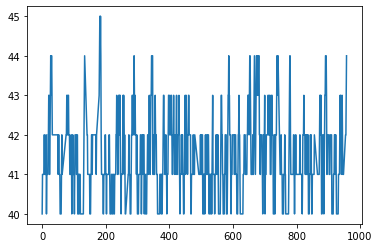

In [40]:
plt.plot(z,o)

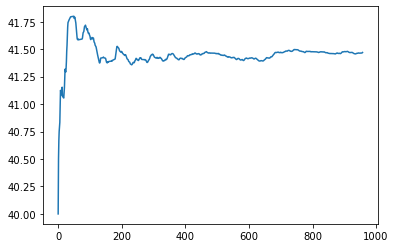

In [41]:
df=pd.DataFrame(o)
avg_data = df.expanding().mean()
arr = np.array(avg_data)
plt.plot(z,arr)

In [42]:
1000/c[-1]

1.0446254072092052

In [51]:
a[3]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1.])

In [70]:
process_vector_n_reps = np.where(process_vector_n_reps > 1, 1, process_vector_n_reps)

In [71]:
process_vector_n_reps

array([[1.        , 0.8725243 , 0.84673363, ..., 1.        , 0.84640588,
        0.9118085 ],
       [1.        , 0.84784122, 1.        , ..., 1.        , 0.95333707,
        0.92151035],
       [0.84327125, 0.9178935 , 1.        , ..., 0.93611232, 0.95529705,
        0.94671902],
       ...,
       [0.87045298, 0.92609541, 1.        , ..., 0.85959417, 0.86407022,
        0.76622329],
       [0.92393656, 0.93190374, 0.91144597, ..., 0.79914242, 1.        ,
        0.83475473],
       [1.        , 0.9134014 , 1.        , ..., 0.93067773, 1.        ,
        0.85064817]])

In [69]:
utilization_per_station

array([0.92745105, 0.93727047, 0.93855606, 0.9311499 , 0.93605609,
       0.93941469, 0.93146687, 0.9291242 , 0.92165851, 0.92451082,
       0.9242518 , 0.94165479, 0.92170962, 0.91755421, 0.92424257,
       0.92941714, 0.92939509, 0.93584805, 0.93115892, 0.92335258,
       0.92399386, 0.92090922, 0.91496724, 0.93692268, 0.93135551,
       0.92786667, 0.9227964 , 0.9328911 , 0.92061511, 0.93109178,
       0.92975487, 0.94151473, 0.9288327 , 0.9303896 , 0.919836  ,
       0.92382673, 0.93035767, 0.9311502 , 0.91802517, 0.9187978 ])

In [63]:
utilization_per_station

array([1.01239502, 1.00797832, 1.0098158 , 1.00954355, 1.01208563,
       1.01242458, 1.        , 1.05067828, 1.01360662, 1.01517658,
       1.01339002, 1.01046   , 1.        , 1.00924573, 1.00881333,
       1.01318122, 1.00820667, 1.00984282, 1.01102946, 1.        ,
       1.01122768, 1.0128444 , 1.00865687, 1.01359914, 1.01516287,
       1.00941384, 1.01328044, 1.        , 1.01289275, 1.01400873,
       1.        , 1.01313837, 1.        , 1.01334747, 1.        ,
       1.01177612, 1.00906936, 1.00688617, 1.        , 1.        ])

In [60]:
time_on_conveyor, time_in_system, throughput, utilization_per_station, throughput, utilization_per_station = metrics(100, time_stamps, time_in_station, rework_tally, rework_time, process_vector_n_reps)

ValueError: not enough values to unpack (expected 6, got 4)

In [28]:
time_on_conveyor

NameError: name 'time_on_conveyor' is not defined

In [56]:
time_in_system

array([55.86299987, 48.17671861, 55.23088401, 52.1811131 , 49.81185998,
       54.05762784, 46.50825638, 50.28030911, 59.83942799, 47.28734663,
       53.45535537, 47.52431245, 54.44063411, 55.20094008, 44.26635183,
       44.38359411, 50.0961049 , 46.0024281 , 55.81495947, 52.18138704,
       46.41065694, 51.34801126, 50.96433497, 50.59640569, 49.09005631,
       49.49876574, 51.00009066, 52.21962426, 54.47073776, 59.95540114,
       48.73744628, 54.15371531, 46.70836453, 50.84568528, 54.78223957,
       44.93551668, 48.30426049, 52.43034136, 48.8632597 , 44.88386121,
       47.5895558 , 52.79847462, 47.80163232, 59.69489697, 59.73435399,
       47.85383465, 53.93564964, 51.0029653 , 50.58033589, 47.04535461,
       48.52257949, 51.23514904, 47.5044354 , 52.72615109, 45.06473357,
       50.88273937, 51.08819784, 52.28789888, 55.02603966, 48.5877812 ])

In [57]:
throughput

0.5363267504511178

### To be done
- Functions for rework
- Write loops for Time / Clock
- Determine metrics and write functions for them
- Plot stuff to show off
- Decide outline of the report
- Make sure to include everything taught in the class
    - Input Analysis
    - RNG
    - Output Analysis 
    - And what not


In [60]:
#station state
np.sum(np.shape(a)[1] - np.sum(a,axis=1))#number of times line stopped due to equipment failure out of cars*40 times

256.0

In [92]:
#repair time
repair_time = np.zeros(p)
for i in range(p):
    temp = np.trace(b[i:i + 40])
    repair_time[i] = temp

In [98]:
len(np.unique(repair_time))
np.sum(repair_time)

1756.5858

In [97]:
len(np.unique(b))

245

In [74]:
repair_time

array([0., 0., 0., ..., 0., 0., 0.])

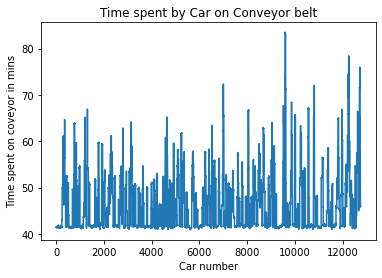

In [99]:
#time on conveyor
fig= plt.figure()
ax= plt.axes()
x= np.linspace(0,p,p)
ax.plot(x,h)
plt.xlabel('Car number')
plt.ylabel('Time spent on coveyor in mins')
plt.title('Time spent by Car on Conveyor belt')
plt.show()

In [112]:
def sim_rep(n_days):
    arrss=[]
    arrrt=[]
    arrts=[]
    arrtis=[]
    arrrtally=[]
    arr_rework=[]
    arr_pv=[]
    arr_toc=[]
    arr_time_in_sys=[]
    arr_thr=[]
    arr_uti=[]
    arr_rework_per_car=[]
    arr_Wr=[]
    arr_eff=[]
    arrWIP=[]
    arrcar=[]
    for i in range(n_days):
        station_state, repair_time, time_stamps, time_in_station, rework_tally, rework_time, process_vector_n_reps, time_on_conveyor, time_in_system, throughput, utilization_per_station, rework_per_car, WIP_rework, efficiency, WIP_in_system, cars= simulate(960)
        arrss.append(station_state)
        arrrt.append(repair_time)
        arrts.append(time_stamps)
        arrtis.append(time_in_station)
        arrrtally.append(rework_tally)
        arr_rework.append(rework_time)
        arr_pv.append(process_vector_n_reps)
        arr_toc.append(time_on_conveyor)
        arr_time_in_sys.append(time_in_system)
        arr_thr.append(throughput)
        arr_uti.append(utilization_per_station)
        arr_rework.append(rework_per_car)
        arr_Wr.append(WIP_rework)
        arr_eff.append(efficiency)
        arrWIP.append(WIP_in_system)
        arrcar.append(cars)
    return arrss, arrrt, arrts, arrtis, arrrtally, arr_rework, arr_pv, arr_toc, arr_time_in_sys, arr_thr, arr_uti, arr_rework, arr_Wr, arr_eff,arrWIP, arrcar


     

In [113]:
station_state, repair_time, time_stamps, time_in_station, rework_tally, rework_time, process_vector_n_reps, time_on_conveyor, time_in_system, throughput, utilization_per_station, rework_per_car, WIP_rework, efficiency, WIP_in_system,cars = sim_rep(5)

In [197]:
for j in range(n_days):
    timestamp=arrts[0:-40]
print(timestamp)
np.shape(timestamp)

[array([0.00000000e+00, 1.03265745e+00, 2.14268396e+00, 3.29706657e+00,
       4.30095812e+00, 5.33993033e+00, 6.37734744e+00, 7.45231088e+00,
       8.45231088e+00, 9.49800405e+00, 1.05849960e+01, 1.16414399e+01,
       1.26944325e+01, 1.36944325e+01, 1.47717832e+01, 1.58847447e+01,
       1.69326537e+01, 1.79408499e+01, 1.89408499e+01, 1.99423979e+01,
       2.09789710e+01, 2.19789710e+01, 2.30586009e+01, 2.40789387e+01,
       2.51805945e+01, 2.62819125e+01, 3.44169974e+01, 3.54169974e+01,
       3.64343380e+01, 3.74608680e+01, 3.85182545e+01, 3.95503239e+01,
       4.05950276e+01, 4.16085920e+01, 4.26085920e+01, 4.36595165e+01,
       4.47185007e+01, 4.58667652e+01, 4.69271717e+01, 4.79717756e+01,
       4.89717756e+01, 5.01295614e+01, 5.11794512e+01, 5.22260953e+01,
       5.33175754e+01, 5.43765235e+01, 5.53765235e+01, 5.64099914e+01,
       5.75401316e+01, 5.85401316e+01, 5.96810008e+01, 6.72841008e+01,
       6.83139497e+01, 6.93459425e+01, 7.03459425e+01, 7.13623284e+01,
     

(30, 960)

In [143]:
toc_avg = np.mean(arr_toc, axis =1)
print(toc_avg)
print(len(toc_avg))

[47.27100924 49.75961952 48.99844184 44.99911119 45.41086445 44.48431252
 47.57120077 46.86102375 49.0464179  47.46333597 47.04709471 48.18618963
 49.0457068  49.97782747 46.76604474 48.224177   47.49469516 45.65455078
 46.35641324 48.83527649 49.41262241 48.26257019 47.08595661 45.91993071
 47.48376038 47.6807264  45.62541185 47.36334517 51.62015492 47.98415504
 45.05592309 46.4262473  48.89723452 47.2595642  47.17234977 43.75827555
 45.93049234 49.95589803 47.18913897 47.44969429 47.40130138 48.39651891
 47.74981634 48.37711891 46.51204551 46.65413134 46.74647677 46.68584491
 46.98416828 47.59004942 48.14610766 46.79442613 46.82652276 47.42634065
 47.05885132 47.04303303 48.65289991 48.7230575  45.63795642 47.79543756
 49.50380143 48.06022754 47.28400131 46.89641276 45.89486571 46.99320172
 46.69532273 47.24330591 49.08277025 46.85380124]
70


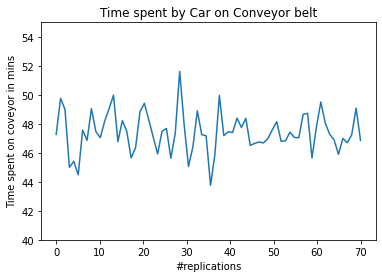

95%CI for Time on conveyor = [47.091,47.729] minutes


In [154]:
fig= plt.figure()
ax= plt.axes()
x= np.linspace(0,70,70)
ax.plot(x,toc_avg)
plt.xlabel('#replications')
plt.ylabel('Time spent on coveyor in mins')
plt.title('Time spent by Car on Conveyor belt')
plt.ylim(ymax=55, ymin=40)
plt.show()
toc_CI = ss.norm.interval(alpha = 0.95, loc= np.mean(toc_avg), scale = np.std(toc_avg)/math.sqrt(len(toc_avg)))
print(f"95%CI for Time on conveyor = [{round(toc_CI[0],3)},{round(toc_CI[1],3)}] minutes") 

In [149]:
rework_tally_per_station = np.sum(rework_tally, axis= 0)
print(rework_tally_per_station)


[ 0.  0.  0.  0.  0.  0. 46.  0.  0.  0.  0.  0. 46.  0.  0.  0.  0.  0.
  0. 46.  0.  0.  0.  0.  0.  0.  0. 49.  0.  0. 51.  0. 47.  0. 40.  0.
  0.  0. 60. 47.]


(array([31.,  0.,  0.,  0.,  0.,  0.,  1.,  5.,  2.,  1.]),
 array([ 0.,  6., 12., 18., 24., 30., 36., 42., 48., 54., 60.]),
 <BarContainer object of 10 artists>)

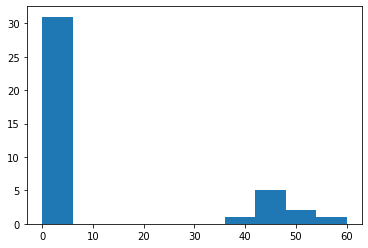

In [152]:
fig= plt.figure()
ax= plt.axes()
plt.hist(rework_tally_per_station)

In [156]:
#Time in system
#print(arr_time_in_sys)
tis_avg = np.mean(arr_time_in_sys, axis =1)
print(tis_avg)
print(len(tis_avg))

[48.50233174 51.11080192 50.27067434 46.32635054 46.73810205 45.79860035
 48.83396142 48.1502732  50.34319572 48.78301293 48.33535188 49.44357115
 50.43262267 51.27680063 48.10844517 49.41754819 48.87238875 46.914726
 47.5541765  50.15587367 50.69544817 49.54316487 48.38462748 47.22674821
 48.71963919 48.94716325 46.94030739 48.73725365 52.97899416 49.37804559
 46.37815309 47.74568904 50.21238474 48.4878492  48.44798977 45.04974088
 47.21241897 51.33926444 48.51530603 48.73899907 48.74917431 49.51384098
 49.03883036 49.75771837 47.79076442 47.98760395 48.17176644 47.93738871
 48.17947415 48.94927496 49.4803294  48.01105711 48.08104439 48.74875923
 48.42729969 48.31214651 49.93082654 50.14320043 46.91783066 49.14896289
 50.75742947 49.35793982 48.50130599 48.27773939 47.22967147 48.1901865
 47.91985132 48.56818993 50.31657438 48.18885461]
70


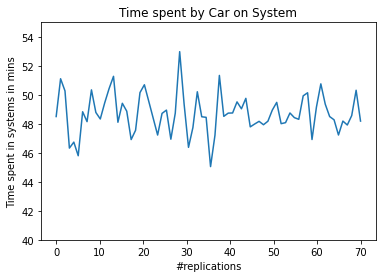

95%CI for Time in system = [48.388,49.03] minutes


In [158]:
fig= plt.figure()
ax= plt.axes()
x= np.linspace(0,70,70)
ax.plot(x,tis_avg)
plt.xlabel('#replications')
plt.ylabel('Time spent in systems in mins')
plt.title('Time spent by Car on System')
plt.ylim(ymax=55, ymin=40)
plt.show()
tis_CI = ss.norm.interval(alpha = 0.95, loc= np.mean(tis_avg), scale = np.std(tis_avg)/math.sqrt(len(tis_avg)))
print(f"95%CI for Time in system = [{round(tis_CI[0],3)},{round(tis_CI[1],3)}] minutes") 

In [160]:
print(arr_thr)

[0.8497730743597437, 0.8053007231519602, 0.8227093007016681, 0.8892843752126908, 0.8877758837600648, 0.8993646159845435, 0.8385983588121345, 0.8573511428534282, 0.8108866813627952, 0.8439407434849385, 0.8566242986566726, 0.8420736506551512, 0.816794083304026, 0.7978564665195603, 0.8574940601670838, 0.8315320671107161, 0.8414489290094581, 0.8831758624865764, 0.8624534748091882, 0.819106164001374, 0.8071661363039092, 0.8361845740485885, 0.8495334567707589, 0.8714047184891494, 0.8421808155821967, 0.8296919474806328, 0.8871164039380942, 0.8471576549270569, 0.7760231925423964, 0.8284875156852048, 0.8854378400889366, 0.8616184406785588, 0.8204035875788511, 0.8496669582212641, 0.8467908959795607, 0.9092106032030497, 0.8757116120009577, 0.7988150532700434, 0.8433937100075274, 0.8459367847618435, 0.8437663526691506, 0.8228301823730619, 0.833779088139242, 0.8187839495537483, 0.8681122195116675, 0.8610565600983779, 0.8555415149919231, 0.8592279701234081, 0.8456466920074716, 0.8364370705932535, 0.

0.8452651713201773
95%CI for Throughput = [0.839,0.851] minutes


(array([ 1.,  2.,  4., 10., 12., 20., 10.,  4.,  5.,  2.]),
 array([0.77602319, 0.78934193, 0.80266067, 0.81597942, 0.82929816,
        0.8426169 , 0.85593564, 0.86925438, 0.88257312, 0.89589186,
        0.9092106 ]),
 <BarContainer object of 10 artists>)

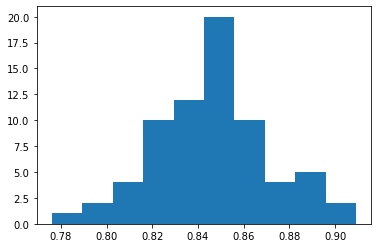

In [168]:
thr_avg = np.mean(arr_thr)
print(thr_avg)
thr_CI = ss.norm.interval(alpha = 0.95, loc= np.mean(arr_thr), scale = np.std(arr_thr)/math.sqrt(len(arr_thr)))
print(f"95%CI for Throughput = [{round(thr_CI[0],3)},{round(thr_CI[1],3)}] minutes") 
plt.hist(arr_thr, bins=10)
# t= np.linspace(0,70,70)
# plt.ylim(ymax=1, ymin=0.6)
# plt.plot(t, arr_thr)

In [177]:
type(arrWIP)

list

In [173]:
arrWIP

[array([40., 40., 41., 41., 41., 41., 41., 41., 40., 40., 40., 41., 41.,
        41., 41., 41., 41., 41., 41., 40., 41., 41., 42., 42., 42., 41.,
        42., 42., 43., 43., 43., 42., 42., 41., 41., 41., 40., 41., 41.,
        41., 41., 41., 40., 40., 40., 40., 40., 40., 41., 42., 42., 42.,
        41., 41., 41., 41., 40., 40., 40., 40., 40., 40., 41., 41., 42.,
        42., 41., 40., 41., 42., 43., 42., 41., 42., 41., 41., 41., 42.,
        40., 41., 41., 42., 43., 42., 43., 42., 43., 43., 42., 43., 42.,
        40., 40., 40., 41., 42., 43., 43., 43., 42., 41., 40., 41., 41.,
        41., 42., 42., 42., 41., 41., 41., 41., 40., 40., 40., 40., 40.,
        40., 40., 41., 41., 41., 41., 40., 40., 40., 40., 41., 42., 42.,
        42., 41., 41., 40., 41., 41., 42., 42., 41., 41., 41., 41., 42.,
        42., 40., 40., 41., 42., 42., 42., 40., 40., 40., 40., 41., 41.,
        42., 43., 43., 41., 41., 40., 41., 41., 42., 42., 41., 41., 40.,
        41., 41., 42., 42., 42., 41., 41., 41., 41.

In [198]:
arrts

[array([0.00000000e+00, 1.03265745e+00, 2.14268396e+00, 3.29706657e+00,
        4.30095812e+00, 5.33993033e+00, 6.37734744e+00, 7.45231088e+00,
        8.45231088e+00, 9.49800405e+00, 1.05849960e+01, 1.16414399e+01,
        1.26944325e+01, 1.36944325e+01, 1.47717832e+01, 1.58847447e+01,
        1.69326537e+01, 1.79408499e+01, 1.89408499e+01, 1.99423979e+01,
        2.09789710e+01, 2.19789710e+01, 2.30586009e+01, 2.40789387e+01,
        2.51805945e+01, 2.62819125e+01, 3.44169974e+01, 3.54169974e+01,
        3.64343380e+01, 3.74608680e+01, 3.85182545e+01, 3.95503239e+01,
        4.05950276e+01, 4.16085920e+01, 4.26085920e+01, 4.36595165e+01,
        4.47185007e+01, 4.58667652e+01, 4.69271717e+01, 4.79717756e+01,
        4.89717756e+01, 5.01295614e+01, 5.11794512e+01, 5.22260953e+01,
        5.33175754e+01, 5.43765235e+01, 5.53765235e+01, 5.64099914e+01,
        5.75401316e+01, 5.85401316e+01, 5.96810008e+01, 6.72841008e+01,
        6.83139497e+01, 6.93459425e+01, 7.03459425e+01, 7.136232

In [218]:
a = np.array(arrts)
arrtsb= a[:,0:-40]
print(np.shape(arrtsb))

(70, 920)


In [204]:
np.shape(arrts1)

(30, 960)

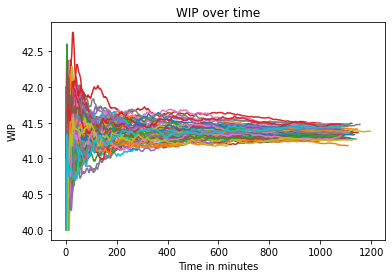

In [227]:
from matplotlib.pyplot import figure
for i in range(70):


# figure(figsize=(8, 20), dpi=80)
    df=pd.DataFrame(arrWIP[i])
    avg_data = df.expanding().mean()
    arr = np.array(avg_data)
    plt.plot(arrtsb[i], arr)
plt.xlabel('Time in minutes')
plt.ylabel('WIP')
plt.title('WIP over time')
plt.show()


Based on our WIP over time, the steady state was achieved for time= 200 mins

95%CI at t=100 = [41.085,41.572]
95%CI at t=200 = [41.167,41.69]
95%CI at t=300 = [41.183,41.674]
95%CI at t=400 = [41.192,41.722]
95%CI at t=500 = [41.224,41.748]
95%CI at t=600 = [41.099,41.587]
95%CI at t=700 = [41.099,41.559]
95%CI at t=800 = [41.144,41.571]
95%CI at t=900 = [41.162,41.666]
95%CI at t=1000 = [41.125,41.704]
95%CI at t=1100 = [41.078,41.55]


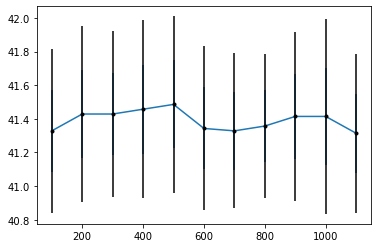

In [232]:
arr = [100,200,300,400,500,600,700,800,900,1000,1100] #time instances at which we want to WIP values
ans = []
a=[]
N= len(arrWIP)
for time in arr:
    vals_arr = []
    for i in range(N):
        idx = None
        flag = False
        for index, t in enumerate(arrtsb[i]):    #identify index closest to arr[i]
            if t < time:
                idx = index
            else:
                flag = True
                vals_arr.append(arrWIP[i][idx])
                break
        if flag == False:
            vals_arr.append(arrWIP[i][idx])
    #print((vals_arr))
    a.append(vals_arr)
#plotting the mean plot
    if vals_arr:
        ans.append(sum(vals_arr)/len(vals_arr))
#CI calculation at each time instance
t = [100,200,300,400,500,600,700,800,900,1000,1100]
for i in range(len(a)):
    temp = ss.norm.interval(alpha = 0.95, loc= np.mean(a[i]), scale = np.std(a[i])/math.sqrt(len(a[i])))
    print(f"95%CI at t={t[i]} = [{round(temp[0],3)},{round(temp[1],3)}]")
    plt.vlines(t[i],temp[1], temp[0])
    plt.errorbar(t[i],np.mean(a[i]),yerr=temp[1]-temp[0], fmt='.k' )


plt.plot(arr,ans)
plt.show()